In [21]:
from __future__ import print_function

import pandas as pd
import numpy as np
import re
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans, MiniBatchKMeans
from pymystem3 import Mystem
import tqdm

%matplotlib inline

# Data

### The table below summarizes the dataset 

|Dataset|Type|Inventory|Corpus|Split|Num. of words|Num. of senses|Avg. num. of senses|Num. of contexts|
|-----|-----|---------|-----|------|:---------:|:----------:|:----------:|:----------:|
|wiki-wiki|main|Wikipedia|Wikipedia|train|4|8|2.0|439
|bts-rnc|main|Gramota.ru|RNC|train|30|96|3.2|3491
|active-dict|main|Active Dict.|Active Dict.|train|85|312|3.7|2073
|active-rnc|additional|Active Dict.|RNC|train|20|71|3.6|1829
|active-rutenten|additional|Active Dict.|ruTenTen|train|21|71|3.4|3671
|bts-rutenten|additional|Gramota.ru|ruTenTen|train|11|25|2.3|956

In [45]:
data = pd.read_csv("../data/main/bts-rnc/train.csv", sep='\t',
                   dtype={'gold_sense_id': str, 'predict_sense_id': str})
data.head()

,context_id,word,gold_sense_id,predict_sense_id,positions,context
0,1,балка,1,NaN,90-94,"маленькой комнаты. Он был очень высок, наклони..."
1,2,балка,1,NaN,69-73,Пантюхин в Склифе сейчас. Он выползти на улицу...
2,3,балка,1,NaN,115-121,равнозначно обеспечивает и меланхоличную езду....
3,4,балка,1,NaN,85-90,"верхняя часть закрыта, замкнута, многократно о..."
4,5,балка,1,NaN,66-70,"по телевизору: наши гол забили, я вскочил от р..."


In [114]:
data_adagram = pd.read_csv("../data/main/bts-rnc/train.baseline-adagram.csv", sep='\t',
                   dtype={'gold_sense_id': str, 'predict_sense_id': str})
data_adagram.head()

,context_id,word,gold_sense_id,predict_sense_id,positions,context
0,1,балка,1,3,90-94,"маленькой комнаты. Он был очень высок, наклони..."
1,2,балка,1,4,69-73,Пантюхин в Склифе сейчас. Он выползти на улицу...
2,3,балка,1,1,115-121,равнозначно обеспечивает и меланхоличную езду....
3,4,балка,1,3,85-90,"верхняя часть закрыта, замкнута, многократно о..."
4,5,балка,1,4,66-70,"по телевизору: наши гол забили, я вскочил от р..."


### Show how many contexts correspond to one word meaning

In [59]:
print('num of unique words: ', len(data.word.unique()))
data.loc[:,['word', 'gold_sense_id', 'context']].groupby(['word', 'gold_sense_id']).count().head(15)

num of unique words:  30


context
word  gold_sense_id         
балка 1                   81
      2                   38
вид   1                   38
      2                    3
      5                   36
винт  1                   39
      2                   67
      3                    1
      5                   16
горн  1                   20
      2                    1
      3                   30
губа  1                  132
      3                    3
      4                    2

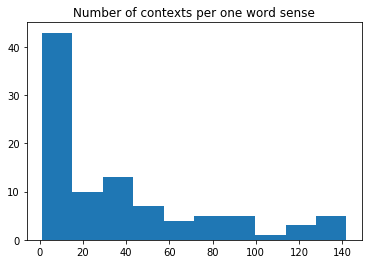

In [56]:
count_per_sense = data.loc[:,['word', 'gold_sense_id', 'context']]\
.groupby(['word', 'gold_sense_id']).['context']

plt.hist(count_per_sense)
plt.title("Number of contexts per one word sense")
plt.show()

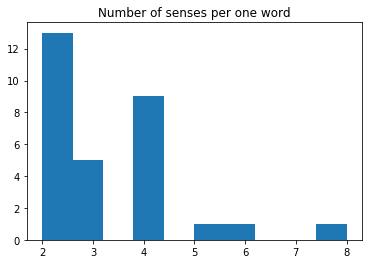

In [225]:
count_senses_per_word = data.loc[:,['word', 'gold_sense_id']]\
.groupby(['word']).nunique()['gold_sense_id']

plt.hist(count_senses_per_word)
plt.title("Number of senses per one word")
plt.show()

# TF IDF + Clustering baseline

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import AffinityPropagation

In [89]:
mystem = Mystem()

def lemmatized_context(s, target_word=None):
    # lemmatize all words and words with '-'
    if target_word is None:
        return [w.lower() for w in mystem.lemmatize(s) if re.match('[\w\-]+$', w)]
    else:
        return [w.lower() for w in mystem.lemmatize(s) if\
                (re.match('[\w\-]+$', w) and w.lower()!=target_word)]

In [90]:
words = data.word.unique()
print(words)

['балка' 'вид' 'винт' 'горн' 'губа' 'жаба' 'клетка' 'крыло' 'купюра'
 'курица' 'лавка' 'лайка' 'лев' 'лира' 'мина' 'мишень' 'обед' 'оклад'
 'опушка' 'полис' 'пост' 'поток' 'проказа' 'пропасть' 'проспект' 'пытка'
 'рысь' 'среда' 'хвост' 'штамп']


In [91]:
X_train, X_test = train_test_split(words, test_size=0.3, random_state=42)

In [92]:
X_train

array(['балка', 'губа', 'обед', 'жаба', 'лира', 'лайка', 'проказа', 'вид',
       'винт', 'пытка', 'горн', 'поток', 'рысь', 'опушка', 'штамп', 'пост',
       'крыло', 'лавка', 'мина', 'полис', 'клетка'], dtype=object)

In [93]:
X_test

array(['среда', 'мишень', 'пропасть', 'оклад', 'купюра', 'курица', 'хвост',
       'проспект', 'лев'], dtype=object)

In [102]:
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, token_pattern='[\w\-]+$')

# TF-IDF fit all contexts

In [100]:
# contexts with target_word
all_contexts = [" ".join(lemmatized_context(c)) for c in data.context]
all_contexts[0]

'маленький комната он быть очень высокий наклонять голова словно подпирать плечо потолочный балка посмотреть на сьянов серьезный черный глаз я из москва быть испытывать здесь'

In [107]:
# contexts without target_word
contexts_without_tword = np.array([" ".join(lemmatized_context(c,w)) for w,c in zip(data.word, data.context)])
contexts_without_tword[0]

'маленький комната он быть очень высокий наклонять голова словно подпирать плечо потолочный посмотреть на сьянов серьезный черный глаз я из москва быть испытывать здесь'

### tf-idf, contexts without target word

In [108]:
contexts_without_tword_transformed = vectorizer.fit_transform(contexts_without_tword)

In [109]:
len(vectorizer.get_feature_names())

382

### Predict fun

In [136]:
def get_labels_for_word(word, all_contexts_vectorized, cluster_model):
    ids = list(data[data.word == word].index)
    X = all_contexts_vectorized[ids]
    golden_labels = data[data.word == word].gold_sense_id
    baseline_labels = data_adagram[data_adagram.word == word].predict_sense_id
    cluster_model.fit(X)
    print('WORD: ', word)
    print("This models ari: ", metrics.adjusted_rand_score(golden_labels, cluster_model.labels_))
    print("Adagram models ari: ", metrics.adjusted_rand_score(golden_labels, baseline_labels))
    print('\n')
    return X, cluster_model.labels_, golden_labels

# DBSCAN

In [125]:
from sklearn.cluster import DBSCAN

In [165]:
db = DBSCAN(eps=0.9,)
db.get_params()

{'algorithm': 'auto',
 'eps': 0.9,
 'leaf_size': 30,
 'metric': 'euclidean',
 'metric_params': None,
 'min_samples': 5,
 'n_jobs': 1,
 'p': None}

In [196]:
tmp = data[data.word.isin(X_train)]
tmp.head()

,context_id,word,gold_sense_id,predict_sense_id,positions,context
0,1,балка,1,NaN,90-94,"маленькой комнаты. Он был очень высок, наклони..."
1,2,балка,1,NaN,69-73,Пантюхин в Склифе сейчас. Он выползти на улицу...
2,3,балка,1,NaN,115-121,равнозначно обеспечивает и меланхоличную езду....
3,4,балка,1,NaN,85-90,"верхняя часть закрыта, замкнута, многократно о..."
4,5,балка,1,NaN,66-70,"по телевизору: наши гол забили, я вскочил от р..."


In [203]:
X_train[0]

'балка'

In [211]:
import warnings
warnings.simplefilter('ignore')

In [212]:
for word in X_train:
    X, pred_labels, golden_labels = get_labels_for_word(word, contexts_without_tword_transformed, db)
    tmp.loc[tmp.word == word,'predict_sense_id'] = pred_labels

WORD:  балка
This models ari:  -0.0149682340721
Adagram models ari:  0.219333489332


WORD:  губа
This models ari:  -0.00790558743572
Adagram models ari:  0.0115319590965


WORD:  обед
This models ari:  -0.0409023281082
Adagram models ari:  0.109923377765


WORD:  жаба
This models ari:  0.0111378529531
Adagram models ari:  0.153283825274


WORD:  лира
This models ari:  0.0316205533597
Adagram models ari:  0.624677947218


WORD:  лайка
This models ari:  0.0323031882436
Adagram models ari:  -0.0286259541985


WORD:  проказа
This models ari:  -0.0126600733053
Adagram models ari:  0.49553256338


WORD:  вид
This models ari:  -0.0175631247147
Adagram models ari:  0.174318665765


WORD:  винт
This models ari:  0.0108950106824
Adagram models ari:  0.278357151237


WORD:  пытка
This models ari:  0.031770911911
Adagram models ari:  0.0263722039155


WORD:  горн
This models ari:  -0.0199372346317
Adagram models ari:  0.148054197859


WORD:  поток
This models ari:  0.00728145242565
Adagram models

In [207]:
tmp

,context_id,word,gold_sense_id,predict_sense_id,positions,context
0,1,балка,1,-1,90-94,"маленькой комнаты. Он был очень высок, наклони..."
1,2,балка,1,-1,69-73,Пантюхин в Склифе сейчас. Он выползти на улицу...
2,3,балка,1,0,115-121,равнозначно обеспечивает и меланхоличную езду....
3,4,балка,1,1,85-90,"верхняя часть закрыта, замкнута, многократно о..."
4,5,балка,1,-1,66-70,"по телевизору: наши гол забили, я вскочил от р..."
5,6,балка,1,-1,77-81,вы взглянете на стену нашего театра возле ЦУМа...
6,7,балка,1,-1,85-89,"плите приварены стойки 13, на которых смонтиро..."
7,8,балка,1,1,57-61,засунуть свой сверток? Да в одни и те же места...
8,9,балка,1,-1,100-104,"активно шла работа по переработке металлолома,..."
9,10,балка,1,-1,101-106,"основания, находится место, где частенько соби..."


# Visualization

In [168]:
X, pred_labels, golden_labels = get_labels_for_word('поток', contexts_without_tword_transformed, db)
pred_labels

WORD:  поток
This models ari:  0.00728145242565
Adagram models ari:  0.0590943613372




array([-1, -1,  0,  0,  0, -1,  0,  0,  0, -1,  1, -1,  0, -1,  1,  0,  0,
       -1, -1,  1, -1,  0,  0,  0, -1,  0,  0, -1,  0,  0, -1, -1,  0, -1,
       -1,  0, -1, -1, -1, -1, -1, -1,  0, -1,  0, -1, -1, -1, -1,  0, -1,
       -1, -1, -1,  0, -1,  0,  0, -1, -1,  0,  0,  0,  1,  0, -1,  0,  0,
        0, -1, -1, -1,  0,  0, -1, -1,  0,  0,  0, -1,  0, -1,  0,  0,  0,
        0,  0, -1, -1,  0,  1,  0,  0,  0, -1,  0, -1,  0,  0, -1,  0,  0,
       -1,  0, -1,  0, -1,  0, -1, -1,  0,  0, -1, -1, -1, -1,  0,  0, -1,
        0,  0, -1, -1, -1,  0, -1,  0, -1,  0,  0,  1,  0, -1, -1, -1, -1])

(array([ 65.,   0.,   0.,   0.,   0.,  65.,   0.,   0.,   0.,   6.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

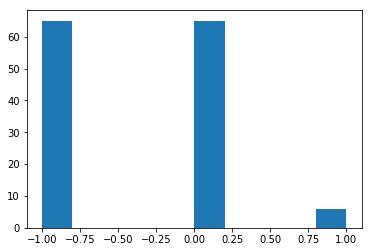

In [169]:
plt.hist(pred_labels)

In [170]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [179]:
def visualize(pred_labels, golden_labels, X):
    pca = PCA(n_components=2, random_state=42)
    viz_x = pca.fit_transform(X.toarray())
    plt.scatter(viz_x[:,0], viz_x[:,1], c=pred_labels, alpha=0.2)
    plt.title("PCA, Predicted labels")
    plt.colorbar()
    plt.show()
    # -----
    plt.scatter(viz_x[:,0], viz_x[:,1], c=golden_labels, alpha=0.2)
    plt.title("PCA, golden labels")
    plt.colorbar()
    plt.show()
    # -----
    tsne = TSNE()
    viz_tsne = tsne.fit_transform(X.toarray())
    plt.scatter(viz_tsne[:,0], viz_tsne[:,1], c=pred_labels, alpha=0.2)
    plt.title("TSNE, Predicted labels")
    plt.colorbar()
    plt.show()
    # -----
    plt.scatter(viz_tsne[:,0], viz_tsne[:,1], c=golden_labels, alpha=0.2)
    plt.title("TSNE, golden labels")
    plt.colorbar()
    plt.show()

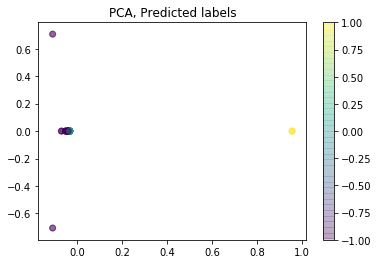

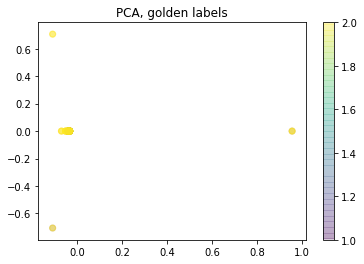

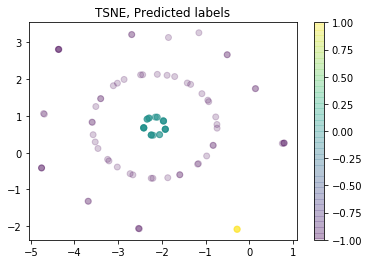

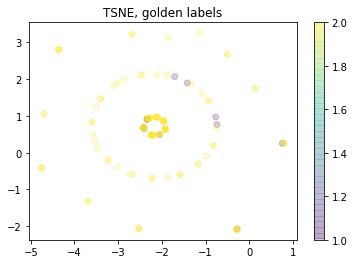

In [180]:
visualize(pred_labels=pred_labels, golden_labels=golden_labels, X=X)

# AffinityPropagation

In [213]:
af = AffinityPropagation()

In [214]:
for word in X_train:
    X, pred_labels, golden_labels = get_labels_for_word(word, contexts_without_tword_transformed, af)
    tmp.loc[tmp.word == word,'predict_sense_id'] = pred_labels

WORD:  балка
This models ari:  0.000334744581675
Adagram models ari:  0.219333489332


WORD:  губа
This models ari:  0.00222342434433
Adagram models ari:  0.0115319590965


WORD:  обед
This models ari:  0.00434456813363
Adagram models ari:  0.109923377765


WORD:  жаба
This models ari:  -0.000749661563429
Adagram models ari:  0.153283825274


WORD:  лира
This models ari:  -0.0054212500394
Adagram models ari:  0.624677947218


WORD:  лайка
This models ari:  0.000129562337327
Adagram models ari:  -0.0286259541985


WORD:  проказа
This models ari:  0.00123727493778
Adagram models ari:  0.49553256338


WORD:  вид
This models ari:  -0.00113965821497
Adagram models ari:  0.174318665765


WORD:  винт
This models ari:  -0.000685613029143
Adagram models ari:  0.278357151237


WORD:  пытка
This models ari:  -0.000338029831076
Adagram models ari:  0.0263722039155


WORD:  горн
This models ari:  -0.00156857824068
Adagram models ari:  0.148054197859


WORD:  поток
This models ari:  -0.0008752924819

In [219]:
X, pred_labels, golden_labels = get_labels_for_word('поток', contexts_without_tword_transformed, af)
pred_labels

WORD:  поток
This models ari:  -0.000875292481916
Adagram models ari:  0.0590943613372




array([  0,   1,   2,   3,   4,   5,   6,   7,   8,  83,  75,   9,  10,
        54,  75,  11,  12,  13,  14,  75,  15,  16,  17,  18,  19,  20,
        21,   7,  22,  23,   2,  24,  25,  26,  27,  28,  29,  54,  30,
        31,  83,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
        43,  44,  45,  46,  47,  48,  89,  49,  50,  51,  52,  75,  53,
        54,  55,  56,  57,  18,  58,  59,  60,  61, 104,  58,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  13,  74,  75,
        76,  77,  78,  79,  80,  30,  81,  82,  83,  84,  85,  86,  87,
        30,  88,  89,  90,  91,  38,  92,  93,  94,  95,  48,  96,  97,
        98,  99, 100, 101, 102, 103, 104, 105,  13, 106, 107, 108, 109,
        75, 110,  13,  83, 111, 112])

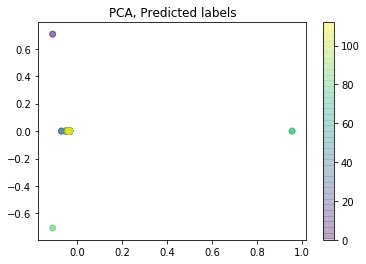

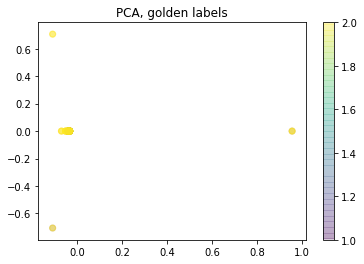

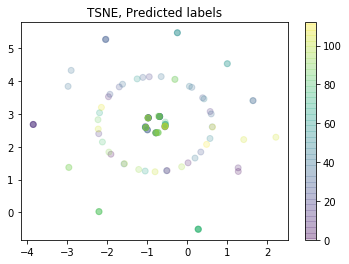

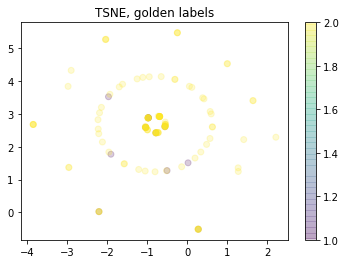

In [221]:
visualize(pred_labels=pred_labels, golden_labels=golden_labels, X=X)

# 4 classes KMeans

In [227]:
from sklearn.cluster import KMeans

In [233]:
km = KMeans(n_clusters=4)

In [234]:
for word in X_train:
    X, pred_labels, golden_labels = get_labels_for_word(word, contexts_without_tword_transformed, km)
    tmp.loc[tmp.word == word,'predict_sense_id'] = pred_labels

WORD:  балка
This models ari:  -0.0327544164703
Adagram models ari:  0.219333489332


WORD:  губа
This models ari:  -0.0497265435791
Adagram models ari:  0.0115319590965


WORD:  обед
This models ari:  -0.024084536235
Adagram models ari:  0.109923377765


WORD:  жаба
This models ari:  0.0261326437373
Adagram models ari:  0.153283825274


WORD:  лира
This models ari:  0.116030422163
Adagram models ari:  0.624677947218


WORD:  лайка
This models ari:  -0.0128029891958
Adagram models ari:  -0.0286259541985


WORD:  проказа
This models ari:  -0.0193226808286
Adagram models ari:  0.49553256338


WORD:  вид
This models ari:  -0.0193017992252
Adagram models ari:  0.174318665765


WORD:  винт
This models ari:  0.0194261509055
Adagram models ari:  0.278357151237


WORD:  пытка
This models ari:  0.0963804601948
Adagram models ari:  0.0263722039155


WORD:  горн
This models ari:  -0.0259732378554
Adagram models ari:  0.148054197859


WORD:  поток
This models ari:  0.0541966585607
Adagram models a

In [238]:
X, pred_labels, golden_labels = get_labels_for_word('поток', contexts_without_tword_transformed, km)
pred_labels

WORD:  поток
This models ari:  -0.00672439161191
Adagram models ari:  0.0590943613372




array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 3, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 3, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1], dtype=int32)

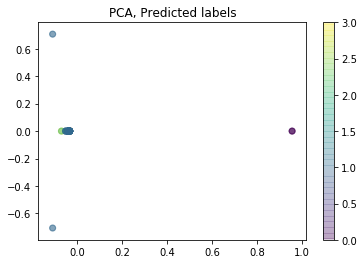

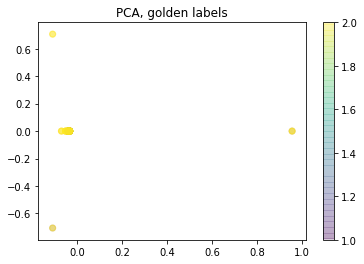

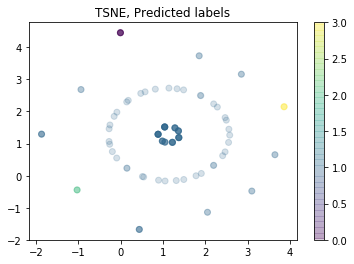

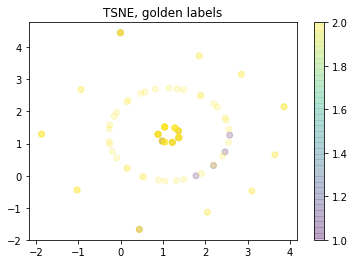

In [239]:
visualize(pred_labels=pred_labels, golden_labels=golden_labels, X=X)

## Compare with adagram

In [240]:
lol = data_adagram[data_adagram.word.isin(X_train)]
lol.head()

,context_id,word,gold_sense_id,predict_sense_id,positions,context
0,1,балка,1,3,90-94,"маленькой комнаты. Он был очень высок, наклони..."
1,2,балка,1,4,69-73,Пантюхин в Склифе сейчас. Он выползти на улицу...
2,3,балка,1,1,115-121,равнозначно обеспечивает и меланхоличную езду....
3,4,балка,1,3,85-90,"верхняя часть закрыта, замкнута, многократно о..."
4,5,балка,1,4,66-70,"по телевизору: наши гол забили, я вскочил от р..."


In [241]:
lol.to_csv("../tmp_res/adagrad.csv", sep='\t', index=False)

## Alternative metrics currently drafted

In [ ]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

# Evaluation

### baseline evaluation

In [242]:
!python3 ../evaluate.py ../tmp_res/adagrad.csv

word	ari	count
балка	0.219333	119
вид	0.174319	77
винт	0.278357	123
горн	0.148054	51
губа	0.011532	137
жаба	0.153284	121
клетка	0.253548	150
крыло	0.232677	91
лавка	0.275710	149
лайка	-0.028626	99
лира	0.624678	49
мина	0.342283	65
обед	0.109923	100
опушка	0.141431	148
полис	0.057707	142
пост	0.653152	144
поток	0.059094	136
проказа	0.495533	146
пытка	0.026372	143
рысь	0.641513	120
штамп	0.432813	96
	0.244642	2406


In [208]:
tmp.to_csv("../tmp_res/dbscan.csv", sep='\t', index=False)

In [209]:
!python3 ../evaluate.py ../tmp_res/dbscan.csv

word	ari	count
балка	-0.014968	119
вид	-0.017563	77
винт	0.010895	123
горн	-0.019937	51
губа	-0.007906	137
жаба	0.011138	121
клетка	0.015442	150
крыло	-0.008823	91
лавка	-0.002383	149
лайка	0.032303	99
лира	0.031621	49
мина	0.008277	65
обед	-0.040902	100
опушка	-0.017183	148
полис	0.000773	142
пост	-0.022061	144
поток	0.007281	136
проказа	-0.012660	146
пытка	0.031771	143
рысь	-0.009885	120
штамп	-0.011078	96
	-0.001815	2406


In [215]:
tmp.to_csv("../tmp_res/affProp.csv", sep='\t', index=False)

In [216]:
!python3 ../evaluate.py ../tmp_res/affProp.csv

word	ari	count
балка	0.000335	119
вид	-0.001140	77
винт	-0.000686	123
горн	-0.001569	51
губа	0.002223	137
жаба	-0.000750	121
клетка	-0.000799	150
крыло	0.005140	91
лавка	-0.000754	149
лайка	0.000130	99
лира	-0.005421	49
мина	0.010869	65
обед	0.004345	100
опушка	0.000199	148
полис	-0.001126	142
пост	-0.001102	144
поток	-0.000875	136
проказа	0.001237	146
пытка	-0.000338	143
рысь	0.000472	120
штамп	0.000864	96
	0.000411	2406


In [235]:
tmp.to_csv("../tmp_res/knn_4.csv", sep='\t', index=False)

In [236]:
!python3 ../evaluate.py ../tmp_res/knn_4.csv

word	ari	count
балка	-0.032754	119
вид	-0.019302	77
винт	0.019426	123
горн	-0.025973	51
губа	-0.049727	137
жаба	0.026133	121
клетка	0.043506	150
крыло	-0.035403	91
лавка	-0.002796	149
лайка	-0.012803	99
лира	0.116030	49
мина	0.006548	65
обед	-0.024085	100
опушка	0.042878	148
полис	0.110292	142
пост	-0.007155	144
поток	0.054197	136
проказа	-0.019323	146
пытка	0.096380	143
рысь	-0.027440	120
штамп	-0.017654	96
	0.013165	2406
